# AskReddit Troll Question Detection Challenge

## Imports

In [113]:
import numpy as np 
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [114]:

import nltk # for tokenizing the paragraphs in sentences and sentences in words
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [115]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/archit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/archit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/archit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [116]:
train_df = pd.read_csv("train.csv")

# train_df.head()
# df = train_df[(train_df == 1).any(axis=1)]
# print(df['question_text'].tolist())

## Preprocessing

### Dropping the qid

In [117]:
train_df.drop(columns=["qid"],inplace=True)
# train_df.head()

### Data Balance Check

[Text(0, 0, '0'), Text(1, 0, '1')]

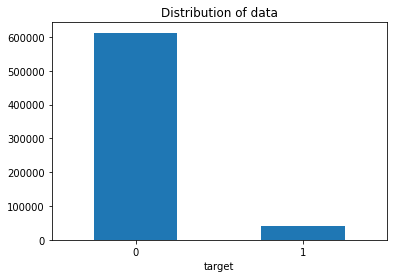

In [118]:
import matplotlib.pyplot as plt

# Plotting the distribution for dataset.
ax = train_df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['0','1'], rotation=0)

### Balancing the data

In [119]:
# from imblearn.over_sampling import SMOTE 

# sm = SMOTE(random_state=23, sampling_strategy=1.0)
# X_train_sm, y_train_sm = sm.fit_resample(train_df['question_text'], train_df['target'])
# print(len(X_train_sm), len(y_train_sm))

# Above cannot be used here as they are in string format

minority_class = train_df[train_df['target']==1]
majority_class = train_df[train_df['target']==0]
for i in range(14):
    train_df = train_df.append(minority_class, ignore_index=True)

print(train_df.shape)
train_df=train_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
# print(train_df.shape)
# print(minority_class.shape)
# print(majority_class.shape)
# print(minority_class[0:100])

(1218731, 2)
(1218731, 2)


[Text(0, 0, '0'), Text(1, 0, '1')]

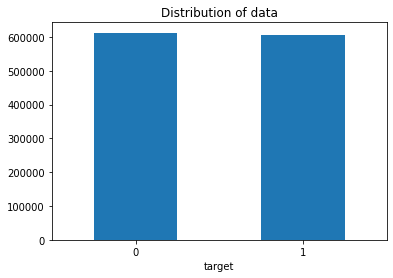

In [120]:
ax = train_df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['0','1'], rotation=0)

### Cleaning the data

- Like removing !?., etc.
- converting sentences to lower case

In [121]:
sentences = train_df['question_text'].tolist()
N = len(sentences)
sentences = sentences[0:N]

In [122]:
i=0
for sentence in sentences:
    temp = re.sub('[^a-zA-Z0-9]', ' ', sentence)
    temp = temp.lower()
    new_sentence = temp.split()
    new_sentence = ' '.join(new_sentence)
    sentences[i] = new_sentence
    # print(new_sentence)
    i+=1

### Lemmatization
- We need to perform Stemming and Lemmatization on the sentences. Lemmatization is prefered as of now (Converting to meaningful words).

In [123]:
lemmatizer = WordNetLemmatizer()

tokenized_sentences = []
for sentence in sentences:
    words = nltk.word_tokenize(sentence)

    # removing stop words and using list composition 
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]

    # joining words using spaces
    tokenized_sentences.append(' '.join(words))

### Data in sentences

In [124]:
sentences = tokenized_sentences
# print(sentences)

## Vectoring Words

#### Bag Of Words

In [125]:
# TODO max_features = 1500 may need to be altered
cv = CountVectorizer()
X1 = cv.fit_transform(sentences)

In [126]:
print(type(X1))
print(X1.dtype)
X1 = X1.astype(float)
print(X1.dtype)

<class 'scipy.sparse.csr.csr_matrix'>
int64
float64


In [127]:
Y1 = train_df['target'].to_numpy().astype(np.float64)
Y1 = Y1[:N]

#### TF IDF

In [128]:
cv = TfidfVectorizer()
X2 = cv.fit_transform(sentences)
# print(X2)

In [129]:
print(type(X2))
X2 = X2.astype(float)
print(X2.dtype)

<class 'scipy.sparse.csr.csr_matrix'>
float64


In [130]:
Y2 = Y1

#### Train test split data

In [131]:
from sklearn.model_selection import train_test_split 

train_X1, test_X1, train_y1, test_y1 = train_test_split(X1, Y1, train_size=0.6)

train_X2, test_X2, train_y2, test_y2 = train_test_split(X2, Y2, train_size=0.6)

## Model generation

In [132]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

#### For data genrated by "Bag of words" method  

In [133]:
lreg1 = LogisticRegression(solver='liblinear')
lreg1.fit(train_X1,train_y1)

LogisticRegression(solver='liblinear')

#### For data generated by "TD IDF" method

In [134]:
lreg2 = LogisticRegression(solver='liblinear')
lreg2.fit(train_X2,train_y2)

LogisticRegression(solver='liblinear')

#### Predict for X1, Y1

In [142]:
train_yhat1 = lreg1.predict_proba(train_X1)
test_yhat1 = lreg1.predict_proba(test_X1)

# print("training score = ", roc_auc_score(train_y1, train_yhat1[:,1]))
# print("test score = ", roc_auc_score(test_y1,test_yhat1[:,1]))

threshold = 0.5

train_output1 = (train_yhat1[:,1] > threshold).astype(int)
test_output1 = (test_yhat1[:,1] > threshold).astype(int)

In [143]:
print("training score = ", f1_score(train_y1.astype(int), train_output1))
print("testing score = ", f1_score(test_y1.astype(int), test_output1))

training score =  0.9327706012938113
testing score =  0.9256508978637981


#### Predict for X2, Y2

In [144]:
train_yhat2 = lreg2.predict_proba(train_X2)
test_yhat2 = lreg2.predict_proba(test_X2)

# print("training score = ", roc_auc_score(train_y2, train_yhat2[:,1]))
# print("test score = ", roc_auc_score(test_y2,test_yhat2[:,1]))

threshold = 0.5

train_output2 = (train_yhat2[:,1] > threshold).astype(int)
test_output2 = (test_yhat2[:,1] > threshold).astype(int)

In [145]:
print("training score = ", f1_score(train_y2.astype(int), train_output2))
print("testing score = ", f1_score(test_y2.astype(int), test_output2))

training score =  0.9254386083532342
testing score =  0.9196604430843359


In [139]:
data = [["question_text","target"]]
for i in range(N):
  data.append([sentences[i],Y1[i]])

In [140]:
import csv

with open('processed_train_data.csv','w',newline='') as fp:
  a = csv.writer(fp, delimiter=',')
  a.writerows(data)

#### Saving Model

In [141]:
# import joblib

# joblib.dump(lreg1,'Using Split LReg1 Model')
# joblib.dump(lreg2,'Using Split LReg2 Model')